In [344]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from datetime import datetime
# import re
# import os
# import json
# import requests
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [286]:
# import data
isco88_soc10 = pd.read_stata("input/onetsoc_to_isco_cws_ibs/isco88_soc00.dta")
soc00_soc10 = pd.read_stata("input/onetsoc_to_isco_cws_ibs/soc00_soc10.dta")
soc10_isco08 = pd.read_stata("input/onetsoc_to_isco_cws_ibs/soc10_isco08.dta")
exposure = pd.read_csv("input/Exposed_to_Disease_or_Infections.csv")
proximity = pd.read_csv("input/Physical_Proximity.csv")
salary = pd.read_excel("input/je-d-03.04.01.02.47.xlsx", skiprows=5)
gender = pd.read_excel("input/su-d-40.02.03.02.01.03.10.xlsx", sheet_name="2018", skiprows=5)

In [287]:
salary.columns = ['ISCO', 'Beruf', 'Unnamed: 2', 'Alle-Total', 'Alle-Frauen', 'Alle-Männer',
       'bis29-Total', 'bis29-Frauen', 'bis29-Männer', '30-49-Total', '30-49-Frauen',
       '30-49-Männer', 'ab50-Total', 'ab50-Frauen', 'ab50-Männer']
salary = salary.iloc[2:49,:]
salary = salary.drop(columns=["Unnamed: 2"])

In [288]:
gender.columns = ['Berufshauptgruppe', 'Berufsgruppe', 'Berufsuntergruppe',
                  'Berufsgattung', 'Berufsart', 'Bezeichnung', 'Total (in T)', 'Männer (in T)',
                  'Frauen (in T)', 'Schweizer (in T)', 'Ausländer (in T)']
gender = gender.iloc[:1484,:]

In [289]:
# Beschränkung auf Berufsgattung (ISCO lvl4)
gender = gender[~pd.isnull(gender.Berufsgattung )].drop(columns=["Berufshauptgruppe", "Berufsgruppe", "Berufsuntergruppe", "Berufsart"])
# Nur Unterketegorien behalten
salary = salary[salary.ISCO.str.len() == 2]

In [290]:
gender = gender.replace('X', np.nan)
gender.Berufsgattung = gender.Berufsgattung.astype(float)

In [291]:
gender['Frauenanteil'] = 100 - (100 / gender['Total (in T)'] * gender['Männer (in T)'])
gender['Auslaenderanteil'] = 100 - (100 / gender['Total (in T)'] * gender['Schweizer (in T)'])
gender = gender.drop(columns=['Männer (in T)', 'Frauen (in T)', 'Schweizer (in T)', 'Ausländer (in T)'])

In [292]:
exposure['soc'] = exposure.Code.apply(lambda x: x[:-3].replace("-",""))
proximity['soc'] = proximity.Code.apply(lambda x: x[:-3].replace("-",""))

In [293]:
def soc_to_isco(soc):
    if len(soc10_isco08.loc[soc10_isco08.soc10 == int(soc), "isco08"]) > 0:
        return soc10_isco08.loc[soc10_isco08.soc10 == int(soc), "isco08"].values[0]
    else:
        return np.nan

In [294]:
exposure['isco08'] = exposure['soc'].apply(soc_to_isco)
proximity['isco08'] = proximity['soc'].apply(soc_to_isco)

In [295]:
exposure['Context'] = exposure['Context'].replace("Not available", np.nan).astype('float')

---

In [255]:
# Überprüfe Einträge die zusammengefasst werden
for code in exposure.isco08.unique():
    print(code)
    print(exposure[exposure.isco08 == code][["Occupation", "Context"]])

2221.0
                              Occupation Context
0                      Acute Care Nurses     100
4                   Critical Care Nurses      99
14                    Nurse Anesthetists      96
19                     Registered Nurses      95
32            Clinical Nurse Specialists      91
47                   Nurse Practitioners      87
66  Advanced Practice Psychiatric Nurses      80
3251.0
          Occupation Context
1  Dental Hygienists     100
2211.0
                          Occupation Context
2   Family and General Practitioners     100
3                Internists, General     100
30            Pediatricians, General      92
2211.5
                                          Occupation Context
5                                       Hospitalists      99
15                                        Urologists      96
16                      Allergists and Immunologists      95
22                        Sports Medicine Physicians      94
23                                   

In [297]:
data = gender.copy()
for index, job in data.iterrows():
    data.loc[index, "Exposure"] = exposure[exposure.isco08 == job["Berufsgattung"]]["Context"].mean()
    data.loc[index, "Proximity"] = proximity[proximity.isco08 == job["Berufsgattung"]]["Context"].mean()

In [299]:
data[['Frauenanteil', 'Exposure']].corr()

,Frauenanteil,Exposure
Frauenanteil,1.000000,0.436176
Exposure,0.436176,1.000000


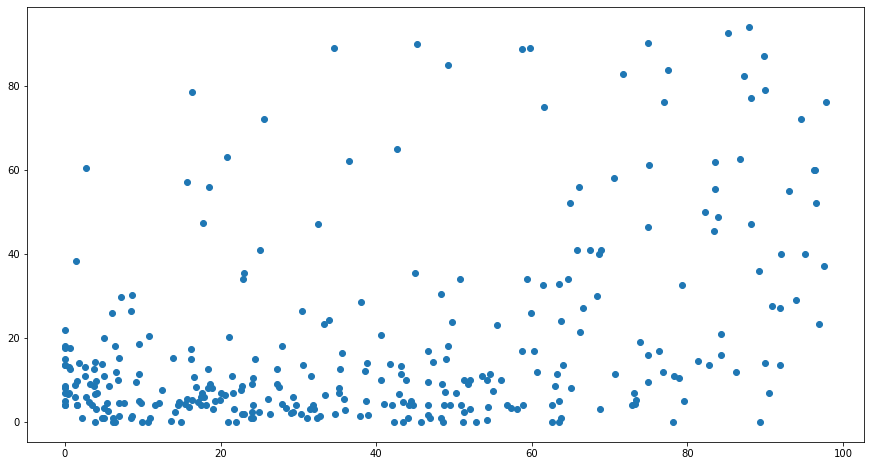

In [357]:
plt.figure(figsize=(15,8))
plt.plot(data['Frauenanteil'], data['Exposure'], 'o')
# m, b = np.polyfit(data['Frauenanteil'], data['Exposure'], 1)
# plt.plot(data['Frauenanteil'], m*data['Frauenanteil'] + b)

In [300]:
data[['Frauenanteil', 'Proximity']].corr()

,Frauenanteil,Proximity
Frauenanteil,1.000000,0.216722
Proximity,0.216722,1.000000


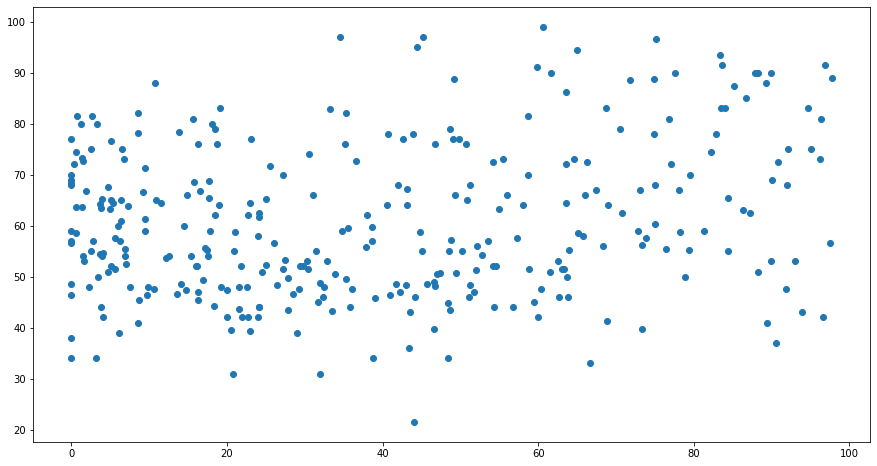

In [359]:
plt.figure(figsize=(15,8))
plt.plot(data['Frauenanteil'], data['Proximity'], 'o')
#m, b = np.polyfit(data['Frauenanteil'], data['Proximity'], 1)
#plt.plot(data['Frauenanteil'], m*data['Frauenanteil'] + b)

In [361]:
data[['Auslaenderanteil', 'Exposure']].corr()

,Auslaenderanteil,Exposure
Auslaenderanteil,1.000000,-0.177044
Exposure,-0.177044,1.000000


In [362]:
data[['Auslaenderanteil', 'Proximity']].corr()

,Auslaenderanteil,Proximity
Auslaenderanteil,1.00000,-0.00519
Proximity,-0.00519,1.00000


In [302]:
data["ISCO_kurz"] = data.Berufsgattung.astype("str").apply(lambda x: x[:-4] if len(x) == 6 else "0"+x[:-4])

In [304]:
data["Total (in T)"].sum()

4357.6137996248835

In [372]:
data[~pd.isnull(data.Exposure)]["Total (in T)"].sum()

3543.9037344465296

In [308]:
## Datensatz beschränken auf Berufe denen auch Werte zugewiesen sind (umfasst 4.4 Mio. Erwerbstätige)
data = data[~pd.isnull(data['Total (in T)'])]

In [366]:
data.reset_index().to_feather("internal/data_large.feather")

In [244]:
data["isco_2"].unique()

array(['01', '02', '03', '10', '11', '12', '13', '14', '20', '21', '22',
       '23', '24', '25', '26', '30', '31', '32', '33', '34', '35', '40',
       '41', '42', '43', '44', '50', '51', '52', '53', '54', '60', '61',
       '62', '63', '70', '71', '72', '73', '74', '75', '80', '81', '82',
       '83', '90', '91', '92', '93', '94', '95', '96', '0'], dtype=object)

In [337]:
data_small = salary.copy()
for index, job in data_small.iterrows():
    exposure_value = 0
    proximity_value = 0
    total_sum = data.loc[(data.ISCO_kurz == job["ISCO"]) & (~pd.isnull(data.Exposure)),"Total (in T)"].sum()
    for i, row in data.loc[(data.ISCO_kurz == job["ISCO"]) & (~pd.isnull(data.Exposure)),:].iterrows():
        exposure_value += row['Exposure'] * row['Total (in T)']
        proximity_value += row['Proximity'] * row['Total (in T)']
    exposure_value = exposure_value / total_sum
    proximity_value = proximity_value / total_sum
    data_small.loc[index, 'Exposure'] = exposure_value
    data_small.loc[index, 'Proximity'] = proximity_value

In [339]:
data_small[['Alle-Total', 'Exposure']].corr()

,Alle-Total,Exposure
Alle-Total,1.000000,0.026344
Exposure,0.026344,1.000000


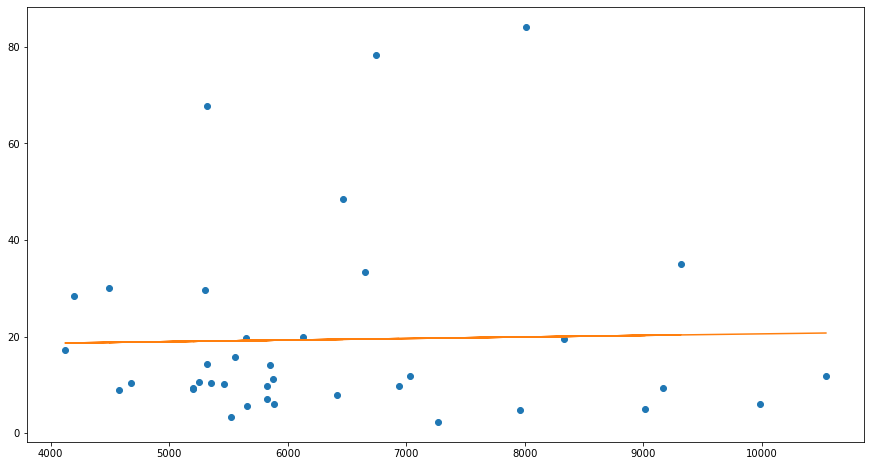

In [354]:
plt.figure(figsize=(15,8))
plt.plot(data_small['Alle-Total'], data_small['Exposure'], 'o')
m, b = np.polyfit(data_small['Alle-Total'], data_small['Exposure'], 1)
plt.plot(data_small['Alle-Total'], m*data_small['Alle-Total'] + b)

In [340]:
data_small[['Alle-Total', 'Proximity']].corr()

,Alle-Total,Proximity
Alle-Total,1.000000,-0.307507
Proximity,-0.307507,1.000000


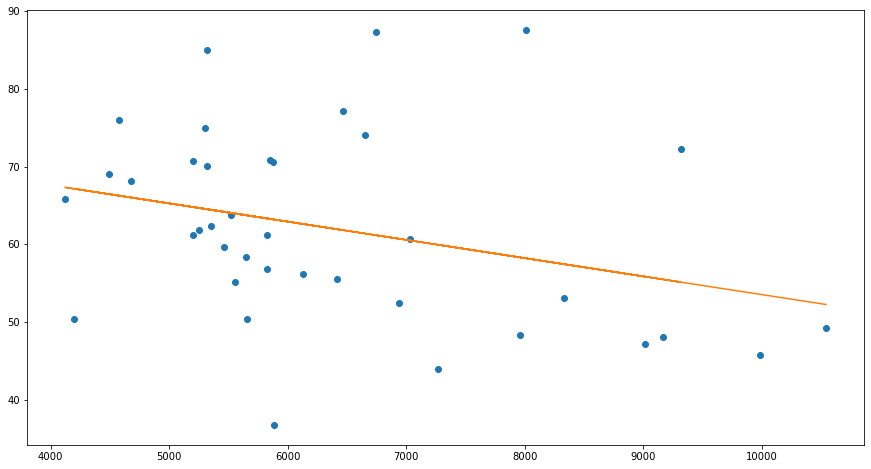

In [355]:
plt.figure(figsize=(15,8))
plt.plot(data_small['Alle-Total'], data_small['Proximity'], 'o')
m, b = np.polyfit(data_small['Alle-Total'], data_small['Proximity'], 1)
plt.plot(data_small['Alle-Total'], m*data_small['Alle-Total'] + b)

In [371]:
data_small[['ISCO', 'Beruf', 'Alle-Total', 'Exposure', 'Proximity']].reset_index().to_feather("internal/data_small.feather")

In [373]:
data_small

,ISCO,Beruf,Alle-Total,Alle-Frauen,Alle-Männer,bis29-Total,bis29-Frauen,bis29-Männer,30-49-Total,30-49-Frauen,30-49-Männer,ab50-Total,ab50-Frauen,ab50-Männer,Exposure,Proximity
3,11,"Geschäftsführer/innen, leitende Funktionen in ...",10541.0,8825,11100.0,6564,[6 188],7040,9882.0,8685,10196.0,11886,9884,12252,11.877232,49.238839
4,12,Führungskräfte im kaufmännischen Bereich,9989.0,8388,10834.0,6327,6016,6706,10018.0,8835,10655.0,11390,9370,12072,6.066572,45.766402
5,13,Führungskräfte in Produktion und spezialisiert...,9170.0,8443,9522.0,6305,6174,6398,8947.0,8353,9183.0,10075,9111,10515,9.283978,48.029985
6,14,"Führungskräfte in Hotels, Restaurants, Handel ...",5199.0,4900,6050.0,4649,4608,4755,5435.0,4980,6073.0,[5 743],5114,6980,9.195854,70.726633
8,21,"Naturwissenschaftler/innen, Mathematiker/innen...",7956.0,6721,8287.0,6190,5776,6331,8000.0,6975,8253.0,10005,8695,10113,4.864655,48.354484
9,22,Akademische und verwandte Gesundheitsberufe,8013.0,7491,9709.0,6364,6302,6526,8446.0,8000,9599.0,10864,9000,13714,84.171136,87.610143
10,23,Lehrkräfte,9315.0,8912,10223.0,6616,6658,6400,8946.0,8641,9563.0,10686,10122,11513,35.106380,72.222229
11,24,Betriebswirtschafter/innen und vergleichbare a...,7265.0,6933,7570.0,5677,5790,5555,7811.0,7467,8123.0,8147,7449,8688,2.314023,43.946683
12,25,Akademische u. vergleichb. Fachkräfte in der I...,9018.0,8244,9115.0,6441,6143,6479,9158.0,8610,9206.0,10457,9354,10538,5.042334,47.184609
13,26,"Juristen/innen, Sozialwissenschaftler/innen un...",8332.0,8036,8777.0,6282,6318,6210,8272.0,8099,8577.0,9347,8904,9751,19.556850,53.046482
